# DeepTesla C
    Proyecto basado en http://selfdrivingcars.mit.edu/deeptesla/

### Objetivo
* Diseñar e implementar una CNN para predecir el ángulo de viraje a partir de imágenes tomadas por la cámara frontal del vehículo.
* Probar y evaluar el desempeño de la red en un simulador de piloto automático.

### Recursos
* Dataset: https://pan.baidu.com/s/1c2J2IFA#list/path=%2F%E5%85%B1%E4%BA%AB%2Fdeeptesla&parentPath=%2F%E5%85%B1%E4%BA%AB
* Documentación de Keras: https://keras.io/
* Documentación de OpenCV: http://opencv.org/
* Introduction to Udacity Self-Driving Car Simulator: https://medium.com/towards-data-science/introduction-to-udacity-self-driving-car-simulator-4d78198d301d

### Otros enlaces útiles
* Augmentation based DNN: https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9


## Extracción de frames de los videos

In [ ]:
from __future__ import print_function

import numpy as np
import cv2
import os

base_path = "J:/Datasets/deeptesla/"
validation_set = [9, 10]
frames_writed = 0

# Para cada video...
for video_id in xrange(1, 11):
    video_filename = "epoch%02d_front.mkv" % video_id
    video_path = os.path.join(base_path, video_filename)
    assert os.path.isfile(video_path)

    # Creamos el capturator
    cap = cv2.VideoCapture(video_path)
    print("Capturing from ", video_path)

    # Capturamos el primer frame
    ret, frame = cap.read()
    assert ret

    # Imprimimos su shape
    shape = frame.shape
    print(shape)

    # Mientras queden frames...
    while (ret):
        # Cortamos el frame 
        img = frame[int(shape[0]/2):shape[0], 0:shape[1]]
        # Llevamos la imagen al tamaño de entrada que utilizaremos en la CNN
        img = cv2.resize(img, (128, 64), interpolation=cv2.INTER_AREA)
        # Redimensionamos la imagen como un 4D array
        img = np.resize(img, (64, 128, 3))
        
        # Guardamos la imagen donde corresponda
        if video_id in validation_set:
            image_path = os.path.join(base_path, "validation/frame%05d.jpg" % frames_writed)
        else:
            image_path = os.path.join(base_path, "training/frame%05d.jpg" % frames_writed)
        cv2.imwrite(image_path, img)
        frames_writed += 1
        if frames_writed % 100 == 0:
            print("Writed %d images..." % frames_writed)

        # Display
        #cv2.imshow('frame', frame)
        #cv2.imshow('img', img)

        # User exit?
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

        # Capturamos el siguiente frame
        ret, frame = cap.read()

    # Liberamos el capturator
    cap.release()

cv2.destroyAllWindows()


## Una primera mirada a los datos

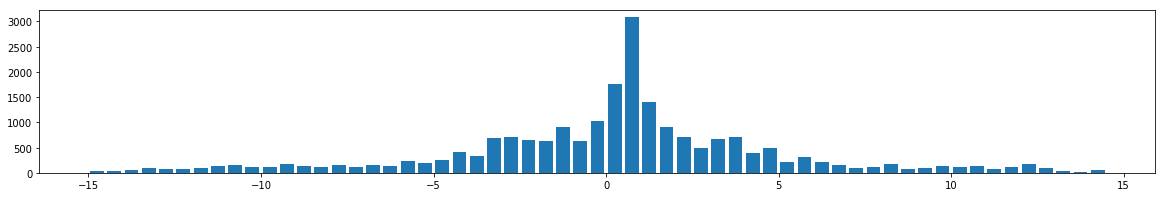

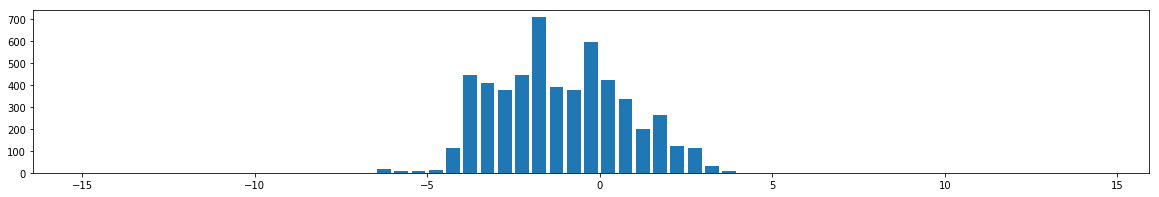

In [7]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np

step = 0.5

y_train = np.genfromtxt("/mnt/j/Datasets/deeptesla/training.csv", delimiter = ',')
y_test = np.genfromtxt("/mnt/j/Datasets/deeptesla/validation.csv", delimiter = ',')

y_train_hist, bins = np.histogram(y_train, bins = np.arange(-15, 15, step))
y_test_hist, bins = np.histogram(y_test, bins = bins)

width = 0.8 * step
center = (bins[:-1] + bins[1:]) / 2

plt.bar(center, y_train_hist, align='center', width=width)
plt.show()
plt.bar(center, y_test_hist, align='center', width=width)
plt.show()


## Entrenamiento de la CNN

In [ ]:
from __future__ import print_function

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
#from keras.layers.advanced_activations import LeakyReLU
from keras import regularizers
from keras.callbacks import EarlyStopping

from PIL import Image
import glob
import os
import numpy as np

# Cantidad de epocas
epochs = 8

batch_size = 16
print("batch_size = %d" % batch_size)

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'deeptesla_trained_model.h5'

x_train = []
x_test = []

filelist = glob.glob("/mnt/j/Datasets/deeptesla/training/*.jpg")
for fname in filelist:
    x_train.append(np.array(Image.open(fname)))
x_train = np.array(x_train)
print(x_train.shape)
print(x_train[0].shape)

filelist = glob.glob("/mnt/j/Datasets/deeptesla/validation/*.jpg")
for fname in filelist:
     x_test.append(np.array(Image.open(fname)))
x_test = np.array(x_test)
        
y_train = np.genfromtxt("/mnt/j/Datasets/deeptesla/training.csv", delimiter = ',')
y_test = np.genfromtxt("/mnt/j/Datasets/deeptesla/validation.csv", delimiter = ',')
print(y_train.shape)

# Modelo
model = Sequential()
model.add(Conv2D(8, (3, 3), padding = 'same',
                 kernel_initializer = 'glorot_uniform',
                 input_shape = x_train[0].shape))
model.add(Activation('elu'))

model.add(Conv2D(16, (3, 3), padding = 'same',
                 kernel_initializer = 'glorot_uniform'))
model.add(Activation('elu'))

model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128))
model.add(Activation('elu'))
model.add(Dropout(0.25))

model.add(Dense(1))
model.add(Activation('linear'))

model.compile(loss = 'mean_squared_error',
              optimizer = 'adadelta')
model.summary()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0.0001,
                          patience = 4,
                          verbose = 1)

model.fit(x_train, y_train,
          batch_size = batch_size,
          epochs = epochs,
          validation_data = (x_test, y_test),
#          shuffle = False,
#          callbacks = [earlystop],
          verbose = 2)

# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)
model.save(model_path)

print('Saved trained model at %s ' % model_path)


## Prueba del modelo

(5400,)
(5400, 1)


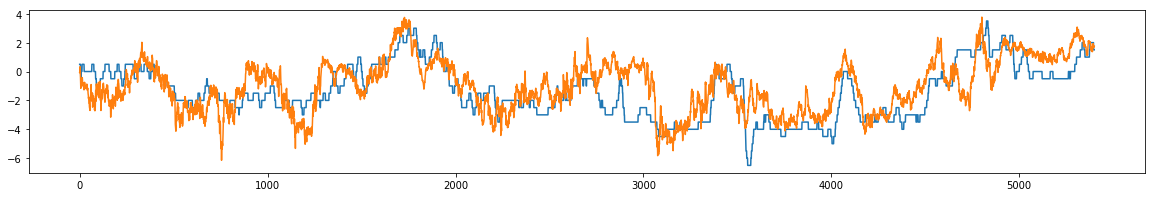

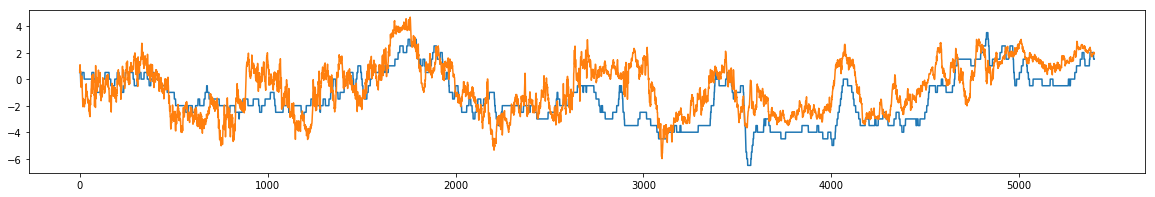

In [6]:
from __future__ import print_function

import keras
from keras import models

from PIL import Image
import os
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt

save_dir = os.path.join(os.getcwd(), 'saved_models')
model1_name = 'deeptesla_floyd_2.h5'
model1_path = os.path.join(save_dir, model1_name)
model2_name = 'deeptesla_floyd_model.h5'
model2_path = os.path.join(save_dir, model2_name)
#model3_name = 'deeptesla_bangho_model.h5'
#model3_path = os.path.join(save_dir, model3_name)

# Cargar los modelos
model1 = models.load_model(model1_path)
model2 = models.load_model(model2_path)
#model3 = models.load_model(model3_path)

x_test = []
filelist = glob.glob("/mnt/j/Datasets/deeptesla/validation/*.jpg")
for fname in filelist:
     x_test.append(np.array(Image.open(fname)))
x_test = np.array(x_test, dtype='float32')
x_test /= 255

y_test = np.genfromtxt("/mnt/j/Datasets/deeptesla/validation.csv", delimiter = ',')
print(y_test.shape)

plt.rcParams["figure.figsize"] = (20, 3)
plt.plot(y_test)
#plt.show()

# Generar predicciones
arr1 = model1.predict(x_test)
arr2 = model2.predict(x_test)
#arr3 = model3.predict(x_test)
print(arr1.shape)

plt.plot(arr1)
plt.show()

plt.figure()
plt.plot(y_test)
plt.plot(arr2)
plt.show()

#plt.figure()
#plt.plot(y_test)
#plt.plot(arr3)
#plt.show()
